# Step 1: Importing necessary libraries

In [45]:
#Importing libraries 
import re
import pandas as pd

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

from pandas import DataFrame 
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from sklearn.metrics import mean_squared_error

<Figure size 640x480 with 0 Axes>

# Step 2: Reading the Dataset

In [46]:
df = pd.read_json('Data/Appliances.json', lines=True) 
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


In [47]:
#checking the shape of data
df.shape

(602777, 12)

# Step 3: Dataset pre-processing 
> Performing product based colloborative filtering

In [48]:
#Grouping by on productId (which is asin) on bases of count and mean
grp_count = df.groupby("asin", as_index=False).count()
#grp_mean = df.groupby("asin", as_index=False).mean()

#joining the dataframes
df_joined = pd.merge(df, grp_count, how='right', on=['asin'])
df_joined.head()

,overall_x,vote_x,verified_x,reviewTime_x,reviewerID_x,asin,style_x,reviewerName_x,reviewText_x,summary_x,...,vote_y,verified_y,reviewTime_y,reviewerID_y,style_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,image_y
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,...,8,45,45,45,45,45,45,45,45,0
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,...,8,45,45,45,45,45,45,45,45,0
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,...,8,45,45,45,45,45,45,45,45,0
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,...,8,45,45,45,45,45,45,45,45,0
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",...,8,45,45,45,45,45,45,45,45,0


In [49]:
#Renames the columns for better clarity. 
df_joined["num_reviewers"] = df_joined["reviewerID_y"]
df_joined["total_score"] = df_joined["overall_x"]
df_joined["review_summary"] = df_joined["summary_x"]

#making a new dataframe containing four columns 
df_final = df_joined[['asin','review_summary','total_score','num_reviewers']]

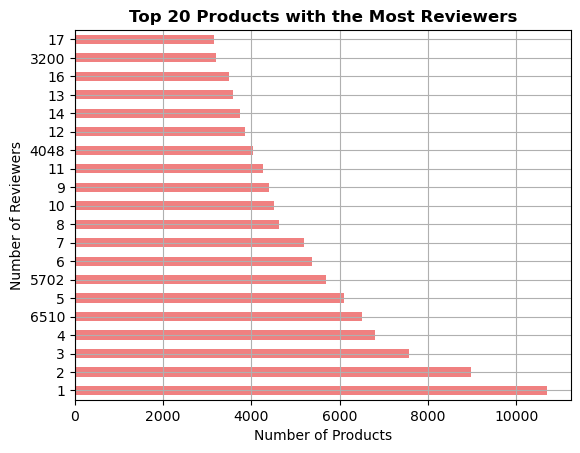

In [50]:
df_joined["num_reviewers"].value_counts()[:20].plot(kind='barh', grid=True , color='lightcoral')
plt.xlabel('Number of Products')
plt.ylabel('Number of Reviewers')
plt.title('Top 20 Products with the Most Reviewers', fontweight="bold")
plt.show()

In [51]:
#selecting reviews which were reviewed by more than 80 users using column num_reviewers
df_joined = df_joined.sort_values(by='num_reviewers', ascending=False)
df_joined_above_80 = df_joined[df_joined.num_reviewers >= 80]
df_joined_above_80.head()

,overall_x,vote_x,verified_x,reviewTime_x,reviewerID_x,asin,style_x,reviewerName_x,reviewText_x,summary_x,...,reviewerID_y,style_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,image_y,num_reviewers,total_score,review_summary
31028,5,NaN,True,"05 14, 2010",A1JCC2Y0H3WZ6C,B000AST3AK,NaN,Marilyn,I should replace my filter every six months. ...,Great filter - the model that goes with my frig.,...,6510,0,6510,6509,6510,6510,46,6510,5,Great filter - the model that goes with my frig.
26820,5,NaN,True,"01 26, 2016",A3P5T4JL9U1WEW,B000AST3AK,NaN,T Parker,I buy this item for my fridge and it works per...,Five Stars,...,6510,0,6510,6509,6510,6510,46,6510,5,Five Stars
26810,5,NaN,True,"01 28, 2016",A2EJBRKGIQN7S,B000AST3AK,NaN,Larry Sharland,Just ordered another one. Works great.,Works great.,...,6510,0,6510,6509,6510,6510,46,6510,5,Works great.
26811,5,NaN,True,"01 28, 2016",A2EMRFKM5DPBFR,B000AST3AK,NaN,Amazon Customer,This item was just as described. it does come...,Mmmmm Water,...,6510,0,6510,6509,6510,6510,46,6510,5,Mmmmm Water
26812,1,NaN,True,"01 27, 2016",A34C4IC39BHMUE,B000AST3AK,NaN,Amazon Customer,Comes with white generic box,One Star,...,6510,0,6510,6509,6510,6510,46,6510,1,One Star


Text(0.5, 1.0, 'Top 20 Products with the Most Reviewers (Reviewed by more than 80 users)')

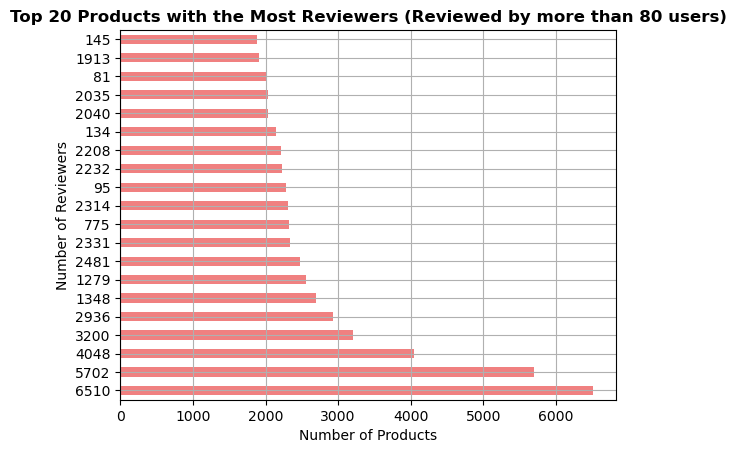

In [52]:
#Plotting graph of reviews which were reviewed by more than 80 users 
df_joined_above_80["num_reviewers"].value_counts()[:20].plot(kind='barh', grid=True , color='lightcoral')
plt.xlabel('Number of Products')  
plt.ylabel('Number of Reviewers')  
plt.title('Top 20 Products with the Most Reviewers (Reviewed by more than 80 users)', fontweight="bold")  

Groups the data by 'asin' and creates a new DataFrame with product summaries listed for each product

In [53]:
#Making final product reviews dataset
df_product = df.groupby("asin", as_index=False).mean()
df_product_review = df_joined_above_80.groupby("asin")["review_summary"].apply(list)
df_product_review = pd.DataFrame(df_product_review)
df_product_review.to_csv("appliances_product_summary.csv")

/var/folders/dd/0k6q11nj127933sr8wm11nhw0000gn/T/ipykernel_77834/1355531510.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_product = df.groupby("asin", as_index=False).mean()


In [54]:
df_product_review.head()

,review_summary
asin,
B00004YWK2,"[Awesomesauce, Works Fantastic, Should have do..."
B00005OU6T,"[Five Stars, Very efficient, but degrades quic..."
B00006IV17,"[Four Stars, Four Stars, Five Stars, Five Star..."
B00007E7RQ,"[Five Stars, it only lasted 1 and 1/2, Five St..."
B00009W3HD,[You have to watch the water level but it's ea...


In [55]:
#merging columns
df_product_review = pd.read_csv("appliances_product_summary.csv")
df_product_review = pd.merge(df_product_review, df_product, on="asin", how='inner')

In [56]:
df_product_review = df_product_review[['asin','review_summary','overall']]
df_product_review.head()

,asin,review_summary,overall
0,B00004YWK2,"['Awesomesauce', 'Works Fantastic', 'Should ha...",3.908046
1,B00005OU6T,"['Five Stars', ""Very efficient, but degrades q...",3.820000
2,B00006IV17,"['Four Stars', 'Four Stars', 'Five Stars', 'Fi...",4.326797
3,B00007E7RQ,"['Five Stars', 'it only lasted 1 and 1/2', 'Fi...",4.126531
4,B00009W3HD,"[""You have to watch the water level but it's e...",3.745583


In [57]:
df_ranges = pd.crosstab(df_product_review['asin'], pd.cut(df_product_review['overall'], [2, 2.5, 3.0, 3.5, 4.0, 4.5, 5]))
df_ranges.head()

overall,"(2.0, 2.5]","(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]","(4.0, 4.5]","(4.5, 5.0]"
asin,,,,,,
B00004YWK2,0,0,0,1,0,0
B00005OU6T,0,0,0,1,0,0
B00006IV17,0,0,0,0,1,0
B00007E7RQ,0,0,0,0,1,0
B00009W3HD,0,0,0,1,0,0


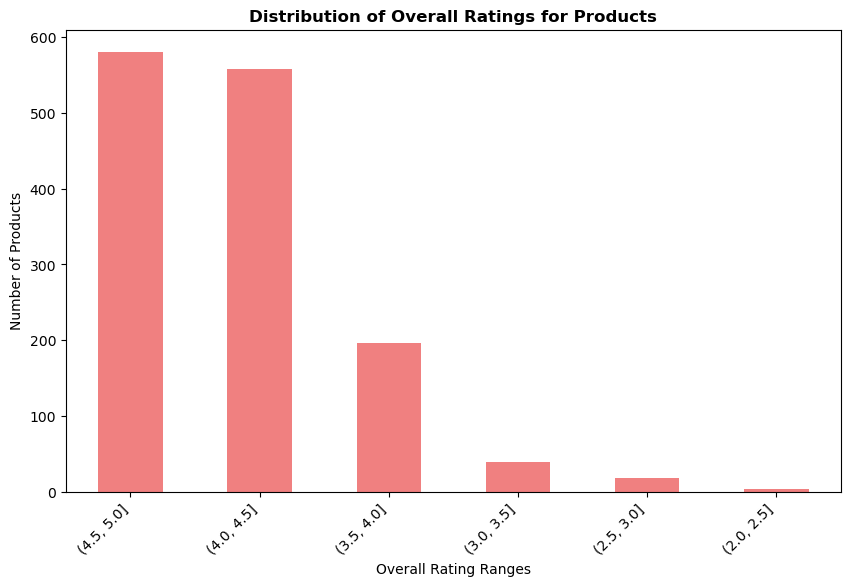

In [58]:

df_ranges.sum().sort_values(ascending=False).plot.bar(color='lightcoral', figsize=(10, 6))
plt.xlabel('Overall Rating Ranges')
plt.ylabel('Number of Products')
plt.title('Distribution of Overall Ratings for Products', fontweight="bold")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


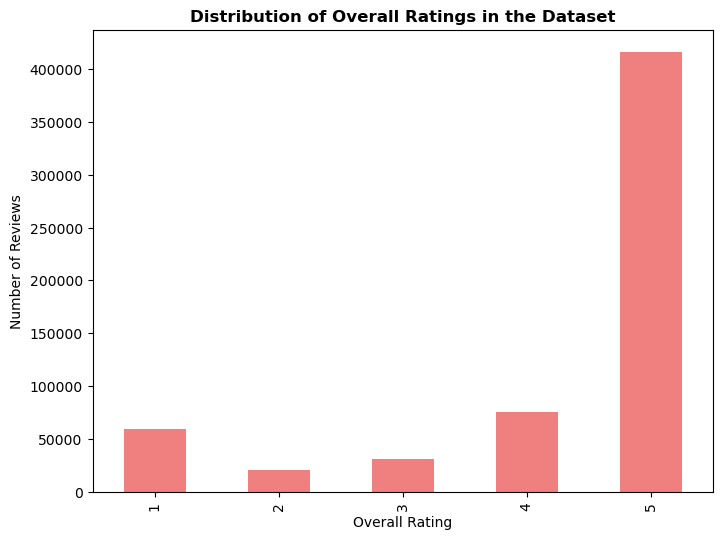

In [59]:

df['overall'].value_counts().sort_index().plot(kind='bar', color='lightcoral', figsize=(8, 6))
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Overall Ratings in the Dataset', fontweight="bold")
plt.show()



# Step 4: Text Cleaning

In [60]:
reg = re.compile('[^a-z]+')
def cleanText(text):
    text = text.lower()
    text = reg.sub(' ', text).strip()
    return text

In [61]:
#drop duplicate rows
df_product_review["cleaned_review"] = df_product_review["review_summary"].apply(cleanText)
df_product_review = df_product_review.drop_duplicates(['overall'], keep='last')
df_product_review = df_product_review.reset_index()

In [62]:
#count vectorization
from sklearn.feature_extraction.text import CountVectorizer
reviews = df_product_review["cleaned_review"] 
countVector = CountVectorizer(max_features = 200, stop_words='english') 
transformed_reviews = countVector.fit_transform(reviews) 




In [63]:
df_reviews = DataFrame(transformed_reviews.A, columns=countVector.get_feature_names_out())
df_reviews = df_reviews.astype(int)

In [64]:
#save the csv file as appliances_reviews
df_reviews.to_csv("appliances_reviews.csv")

# Step 5: Train Test Split

In [65]:
X = np.array(df_reviews)
train_test_ratio = 0.9
size = int(np.floor(train_test_ratio * len(X)))
X_train = X[:size]
X_test = X[size:]

In [66]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_train)
distances, indices = neighbor.kneighbors(X_train)

# Step 6: Finding related products
> Uses the Nearest Neighbors algorithm to find similar products based on their reviews.

In [67]:
#find most related products for users 
for i in range(len(X_test)):
    product_test = neighbor.kneighbors([X_test[i]])
    related_products = product_test[1]

    related_product_1 = [item[0] for item in related_products]
    related_product_1 = str(related_product_1).strip('[]')
    related_product_1 = int(related_product_1)
    
    related_product_2 = [item[1] for item in related_products]
    related_product_2 = str(related_product_2).strip('[]')
    related_product_2 = int(related_product_2)
    
    print ("Based on product reviews, for ", df_product_review["asin"][len(X_train) + i] ," average rating is ",df_product_review["overall"][len(X_train) + i])
    print ("The first similar product is ", df_product_review["asin"][related_product_1] ," average rating is ",df_product_review["overall"][related_product_1])
    print ("The second similar product is ", df_product_review["asin"][related_product_2] ," average rating is ",df_product_review["overall"][related_product_2])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B01BKDEGP0  average rating is  4.11854103343465
The first similar product is  B005AR8KDM  average rating is  4.8311688311688314
The second similar product is  B00KLVGYLM  average rating is  4.36231884057971
-----------------------------------------------------------
Based on product reviews, for  B01BKWSHHE  average rating is  4.427586206896552
The first similar product is  B00RKN7QNE  average rating is  4.512396694214876
The second similar product is  B00L9GB54O  average rating is  4.6581196581196584
-----------------------------------------------------------
Based on product reviews, for  B01BLLM4X2  average rating is  3.9625
The first similar product is  B00RKN7QNE  average rating is  4.512396694214876
The second similar product is  B00YD2XWDI  average rating is  4.418994413407821
-----------------------------------------------------------
Based on product reviews, for  B01BO4HT5E  average rating is  4.143426294820717
The first similar product is  B00M

In [68]:
y_train = df_product_review["overall"][:len(X_train)].apply(np.ceil)
y_test = df_product_review["overall"][len(X_train):len(X_train)+len(X_test)].apply(np.ceil)

 Over Sampling

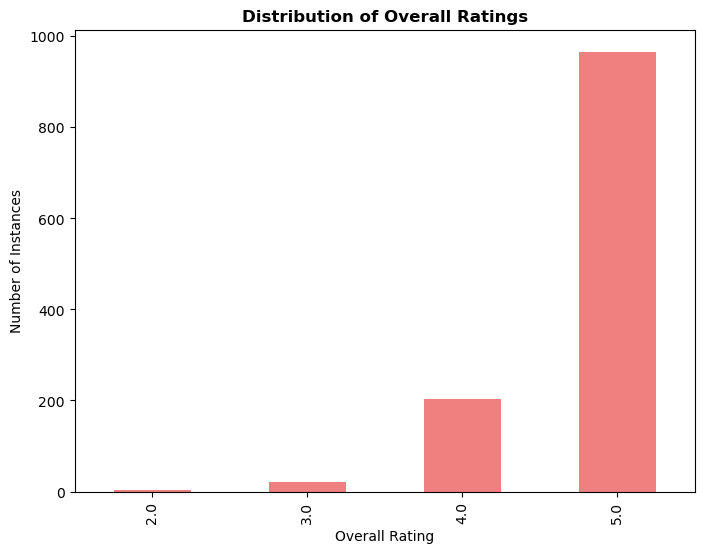

In [69]:
#before over sampling

y_train.value_counts().sort_index().plot(kind='bar', color='lightcoral', figsize=(8, 6))
plt.xlabel('Overall Rating')
plt.ylabel('Number of Instances')
plt.title('Distribution of Overall Ratings', fontweight="bold")
plt.show()


### Applying kNN algorithm 

In [70]:
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         4.0       0.59      0.57      0.58        23
         5.0       0.91      0.92      0.91       110

    accuracy                           0.86       133
   macro avg       0.75      0.74      0.75       133
weighted avg       0.85      0.86      0.86       133



In [71]:
print ("accuracy_score" , accuracy_score(y_test, pred))
print("mean_squared_error" , mean_squared_error(y_test, pred))

accuracy_score 0.8571428571428571
mean_squared_error 0.14285714285714285


In [72]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanText)

In [73]:

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

Generates a word cloud for reviews with a specific score.

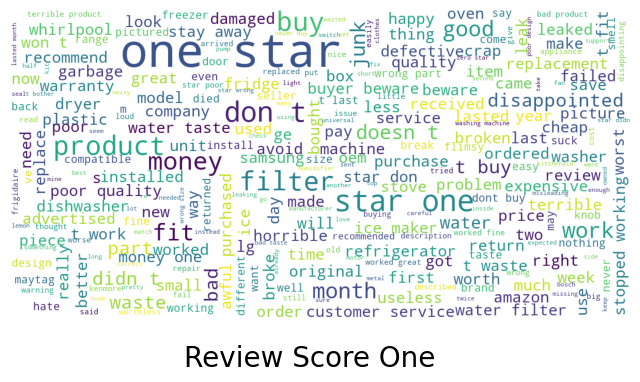

In [74]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

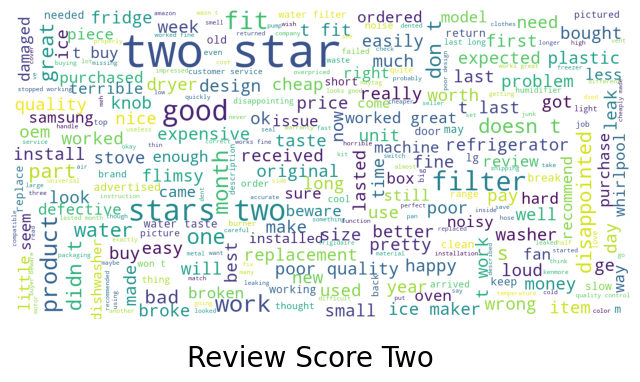

In [75]:
show_wordcloud(cluster1["summaryClean"][1], title = "Review Score Two")

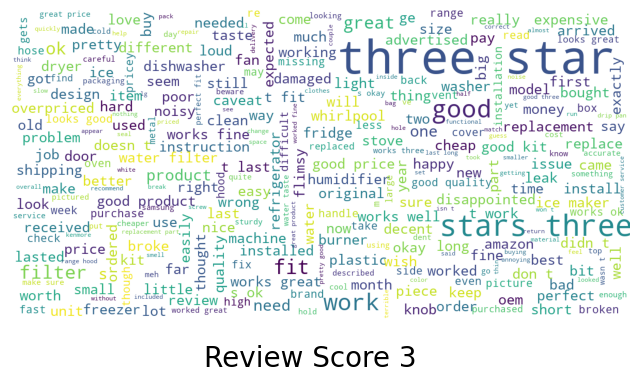

In [76]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score 3")

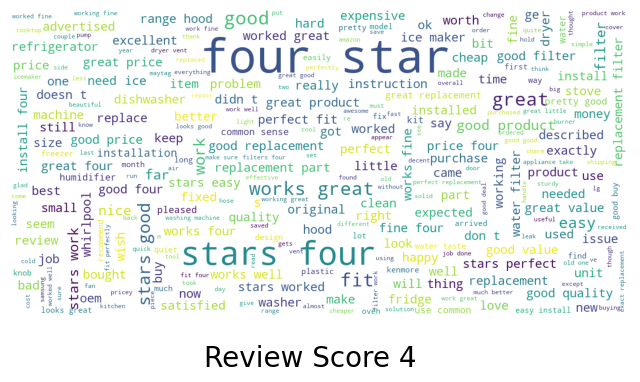

In [77]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score 4")

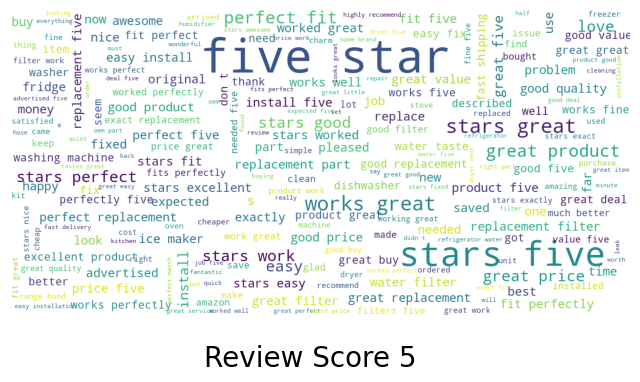

In [78]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score 5")

Evaluates the error rate for different values of k in K-Nearest Neighbors.

In [79]:
errors = []
K = range(1,10)
for k in K:
    model  = neighbors.KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    errors.append(mean_squared_error(y_test, pred))

Text(0, 0.5, 'Error Rate')

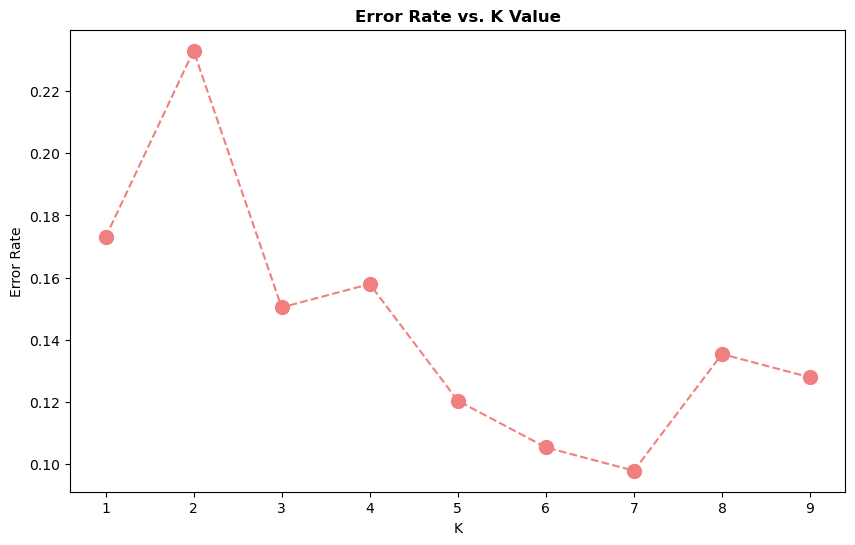

In [80]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10), errors, color='lightcoral', linestyle='dashed', marker='o', markersize=10)
plt.title('Error Rate vs. K Value', fontweight="bold")
plt.xlabel('K')
plt.ylabel('Error Rate')

Prints the classification report, accuracy, and mean squared error for the model

In [81]:
clf = neighbors.KNeighborsClassifier(7, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))
print ("Accuracy: ",accuracy_score(y_test, pred))
print("MSE: ",mean_squared_error(y_test, pred))

              precision    recall  f1-score   support

         4.0       0.86      0.52      0.65        23
         5.0       0.91      0.98      0.94       110

    accuracy                           0.90       133
   macro avg       0.88      0.75      0.80       133
weighted avg       0.90      0.90      0.89       133

Accuracy:  0.9022556390977443
MSE:  0.09774436090225563
